In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from sklearn.utils import resample
from sklearn.utils import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization,MaxPooling2D,Flatten
from sklearn.metrics import f1_score, precision_score, recall_score
from keras.layers import Conv2D,Dense,Dropout,GlobalAveragePooling2D,MaxPool2D
import tensorflow as tf

In [2]:
data_dir='chest_xray'
paths=glob.glob(data_dir+'/*/*/*.jpeg')
print(f'found {len(paths)} images in the dataset')
paths[:5]

found 5856 images in the dataset


['chest_xray\\test\\NORMAL\\IM-0001-0001.jpeg',
 'chest_xray\\test\\NORMAL\\IM-0003-0001.jpeg',
 'chest_xray\\test\\NORMAL\\IM-0005-0001.jpeg',
 'chest_xray\\test\\NORMAL\\IM-0006-0001.jpeg',
 'chest_xray\\test\\NORMAL\\IM-0007-0001.jpeg']

In [3]:
df=pd.DataFrame(paths,columns=['path'])
df['label']=df['path'].apply(lambda x:x.split('\\')[2].strip())
df.head()

,path,label
0,chest_xray\test\NORMAL\IM-0001-0001.jpeg,NORMAL
1,chest_xray\test\NORMAL\IM-0003-0001.jpeg,NORMAL
2,chest_xray\test\NORMAL\IM-0005-0001.jpeg,NORMAL
3,chest_xray\test\NORMAL\IM-0006-0001.jpeg,NORMAL
4,chest_xray\test\NORMAL\IM-0007-0001.jpeg,NORMAL


In [4]:
counts=df['label'].value_counts()
counts

label
PNEUMONIA    4273
NORMAL       1583
Name: count, dtype: int64

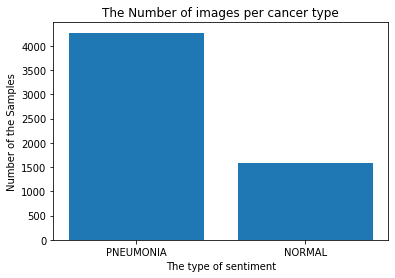

In [5]:
plt.bar(['PNEUMONIA','NORMAL'], counts, width=0.8)
plt.xlabel('The type of sentiment')
plt.ylabel('Number of the Samples')
plt.title("The Number of images per cancer type")
plt.show()

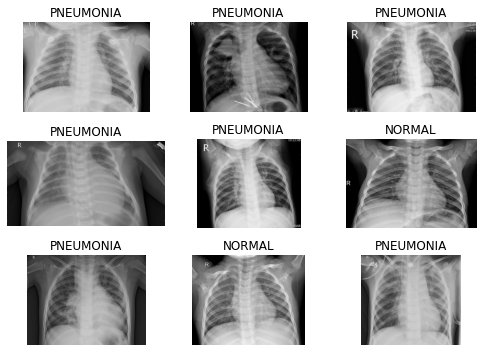

In [6]:
num_images=9
sampled_df = df.sample(n=num_images).reset_index(drop=True)
plt.figure(figsize=(7, 5))
for i in range(num_images):
    plt.subplot(3, 3, i + 1)
    img_path = sampled_df.iloc[i]['path']
    img = plt.imread(img_path)
    plt.imshow(img,cmap='gray')
    plt.title(sampled_df.iloc[i]['label'])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
df['label'] = df['label'].map({'NORMAL': '0', 'PNEUMONIA': '1'})

In [8]:
df['label'].value_counts()

label
1    4273
0    1583
Name: count, dtype: int64

In [9]:
df_majority = df[df.label == '1']
df_minority = df[df.label == '0']
df_majority_downsampled = resample(df_majority,replace=False,n_samples=len(df_minority), random_state=42)  
df = pd.concat([df_minority, df_majority_downsampled])

In [10]:
df['label'].value_counts()

label
0    1583
1    1583
Name: count, dtype: int64

In [11]:
df=df.sample(frac=1.0, random_state=42)
df.head(5)

,path,label
954,chest_xray\train\NORMAL\IM-0517-0001.jpeg,0
1720,chest_xray\train\NORMAL\NORMAL2-IM-1091-0001.jpeg,0
170,chest_xray\test\NORMAL\NORMAL2-IM-0301-0001.jpeg,0
2434,chest_xray\train\PNEUMONIA\person1249_virus_21...,1
343,chest_xray\test\PNEUMONIA\person136_bacteria_6...,1


In [12]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
test_df, valid_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print("Training set shapes:", train_df.shape)
print("Validation set shapes:", valid_df.shape)
print("Testing set shapes:", test_df.shape)

Training set shapes: (2532, 2)
Validation set shapes: (317, 2)
Testing set shapes: (317, 2)


In [13]:
train_df['label'].value_counts()

label
1    1277
0    1255
Name: count, dtype: int64

In [14]:
train_datagen = ImageDataGenerator(    
    rescale=1.0/255,        
    shear_range=0.2,
    rotation_range=.1,
    zoom_range=0.2,       
    horizontal_flip=True ,
)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path', 
    y_col='label',   
    target_size=(150, 150), 
    batch_size=32,
    class_mode='binary', 
    color_mode='rgb',
    shuffle=True
)

# Validation data generator
valid_generator = test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='path', 
    y_col='label',
    target_size=(150, 150), 
    batch_size=32,
    color_mode='rgb',
    class_mode='binary',
    shuffle=False  
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path', 
    y_col='label',  
    target_size=(150, 150),  
    color_mode='rgb',
    batch_size=64,  
    class_mode='binary',
    shuffle=False  
)

Found 2532 validated image filenames belonging to 2 classes.
Found 317 validated image filenames belonging to 2 classes.
Found 317 validated image filenames belonging to 2 classes.


In [15]:
classes=['NORMAL','PNEUMONIA']
classes

['NORMAL', 'PNEUMONIA']

In [16]:
train_generator.image_shape

(150, 150, 3)

In [17]:
from keras.applications import MobileNetV2
mobileNetV2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
for layer in mobileNetV2.layers:
    layer.trainable = False

In [18]:
mobileNet=keras.models.Sequential([
    mobileNetV2,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'), 
    Dropout(0.5),  
    Dense(1, activation='sigmoid') 
])

mobileNet.add(Dense(1,activation='sigmoid'))
mobileNet.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [19]:
mobileNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
 dense_2 (Dense)             (None, 1)                 2

In [20]:
weight_path = "cnn_weights.best.weights.h5"

checkpoint = ModelCheckpoint(weight_path, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=True)

early = EarlyStopping(monitor="val_accuracy", 
                      mode="max", 
                      patience=4)

callbacks_list = [checkpoint, early]

In [21]:
mobileNet_history=mobileNet.fit(train_generator,epochs=5,validation_data=valid_generator,callbacks=callbacks_list)

Epoch 1/5
80/80 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.4961
Epoch 1: val_accuracy improved from -inf to 0.48896, saving model to cnn_weights.best.weights.h5
80/80 [==============================] - 174s 2s/step - loss: 0.6935 - accuracy: 0.4961 - val_loss: 0.6932 - val_accuracy: 0.4890
Epoch 2/5
80/80 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5043
Epoch 2: val_accuracy did not improve from 0.48896
80/80 [==============================] - 126s 2s/step - loss: 0.6932 - accuracy: 0.5043 - val_loss: 0.6932 - val_accuracy: 0.4890
Epoch 3/5
80/80 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5043
Epoch 3: val_accuracy did not improve from 0.48896
80/80 [==============================] - 117s 1s/step - loss: 0.6932 - accuracy: 0.5043 - val_loss: 0.6932 - val_accuracy: 0.4890
Epoch 4/5
80/80 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5043
Epoch 4: val_accuracy did not improve f

In [90]:
# load the best weights
mobileNet.load_weights(weight_path)

In [91]:
evaluation_result = mobileNet.evaluate(test_generator)
print("Test Loss:", evaluation_result[0])
print("Test Accuracy:", evaluation_result[1])

5/5 [==============================] - 37s 8s/step - loss: 0.4386 - accuracy: 0.9243
Test Loss: 0.4385797679424286
Test Accuracy: 0.9242902398109436


In [92]:
y_pred = mobileNet.predict(test_generator)

5/5 [==============================] - 26s 3s/step


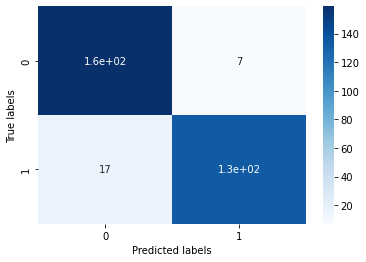

In [93]:
y_pred_binary = np.squeeze(np.round(y_pred))
confusion_Matrix = confusion_matrix(test_generator.classes, y_pred_binary)
sns.heatmap(confusion_Matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

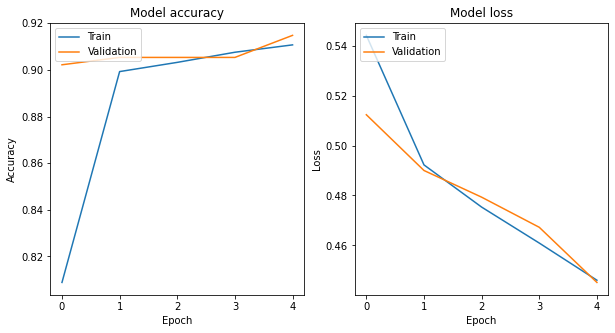

In [94]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# Plot the training and validation accuracy
ax1.plot(mobileNet_history.history['accuracy'])
ax1.plot(mobileNet_history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot the training and validation loss
ax2.plot(mobileNet_history.history['loss'])
ax2.plot(mobileNet_history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

# Display the plots
plt.show()


In [95]:
mobilenet_pred_binary = np.squeeze(np.round(y_pred))
print(classification_report(test_generator.classes, mobilenet_pred_binary))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       166
           1       0.95      0.89      0.92       151

    accuracy                           0.92       317
   macro avg       0.93      0.92      0.92       317
weighted avg       0.93      0.92      0.92       317



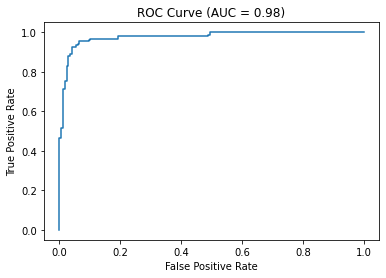

In [96]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(test_generator.classes, y_pred)
auc_score = roc_auc_score(test_generator.classes, y_pred)
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {auc_score:.2f})')
plt.show()



ValueError: in user code:

    File "c:\Users\om\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\om\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\om\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\om\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "c:\Users\om\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\om\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 150, 150, 3)


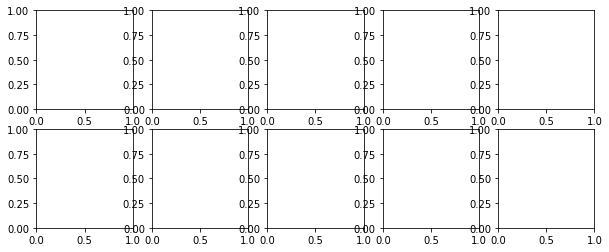

In [98]:
x_test,y_test=next(test_generator)
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
axs = axs.flatten()

for i in range(10):
    predicted = mobileNet.predict(np.array([x_test[testimgnum]]))
    predictedClass = int(predicted >= 0.5)
    actual = int(y_test[i])

    axs[i].imshow(x_test[testimgnum], cmap='gray')
    axs[i].set_title(f'Predicted: {classes[predictedClass]} \nActual: {classes[actual]}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [103]:
import cv2
from tensorflow.keras.preprocessing.image import img_to_array

# Load the image using OpenCV
image_path = r"C:\Users\om\Documents\example\chest_xray\test\NORMAL\IM-0001-0001.jpeg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Resize the image to match the expected input size (150x150)
resized_image = cv2.resize(image, (150, 150))

# Convert the resized image to an array
input_image = img_to_array(resized_image)

# Expand the dimensions to create a batch of size 1
input_image = input_image.reshape((1, 224, 224, 3))

# Perform prediction using the model
prediction = model.predict(input_image)

# Interpret the prediction and take further actions


ValueError: cannot reshape array of size 67500 into shape (1,224,224,3)

In [2]:
from datasets import load_dataset

dataset = load_dataset("CyberNative/Code_Vulnerability_Security_DPO")

Generating train split:   0%|          | 0/4656 [00:00<?, ? examples/s]

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['lang', 'vulnerability', 'system', 'question', 'chosen', 'rejected'],
        num_rows: 4656
    })
})